In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

from data_reading import read_and_combine_csv
from feature_engineering import FeatureEngineer
from config import Config

In [2]:
config = Config()
fe = FeatureEngineer()
fold_name = f'{config.symbols[7]}-spot-klines-15m-from_2018_to_2025'
df = read_and_combine_csv(f'./raw_data/{fold_name}')

正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2022-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2025-01.csv
读取文件失败: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2025-01.csv, 错误: year 56971 is out of range
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2018-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2018-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2022-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2020-08.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2020-09.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2019-02.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2021-06.csv
正在读取文件: ./raw_data/ETHUSDT-spot-klines-15m-from_2018_to_2025/ETHUSDT-15m-2021-12.csv
正在读取文件: ./raw_data/ETHUSDT-spot-k

In [3]:
df

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 08:00:00,733.01,734.52,722.91,727.31,420.84730,2018-01-01 08:14:59.999,3.062671e+05,867,210.68080,1.532772e+05,0
1,2018-01-01 08:15:00,727.22,728.44,720.03,725.51,586.88558,2018-01-01 08:29:59.999,4.250692e+05,890,351.73472,2.546975e+05,0
2,2018-01-01 08:30:00,725.51,728.61,722.85,723.38,522.11912,2018-01-01 08:44:59.999,3.794493e+05,654,298.03786,2.166539e+05,0
3,2018-01-01 08:45:00,723.33,727.62,722.50,727.62,576.04900,2018-01-01 08:59:59.999,4.177735e+05,703,414.77933,3.008165e+05,0
4,2018-01-01 09:00:00,727.01,728.25,723.00,724.64,320.34994,2018-01-01 09:14:59.999,2.324155e+05,474,122.04581,8.860470e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...
244937,2025-01-01 06:45:00,3344.07,3346.45,3329.00,3339.88,2793.12000,2025-01-01 06:59:59.999,9.324333e+06,15324,1411.93770,4.715837e+06,0
244938,2025-01-01 07:00:00,3339.88,3343.91,3328.47,3341.91,2654.69870,2025-01-01 07:14:59.999,8.859294e+06,22124,1374.34410,4.586771e+06,0
244939,2025-01-01 07:15:00,3341.91,3345.98,3335.52,3343.45,1130.91660,2025-01-01 07:29:59.999,3.778152e+06,13363,784.78810,2.621702e+06,0
244940,2025-01-01 07:30:00,3343.45,3344.25,3332.39,3339.06,1284.31850,2025-01-01 07:44:59.999,4.285603e+06,12596,630.57880,2.104125e+06,0


In [4]:
df.rename({'Close': 'close',
           'Open': 'open',
           'High': 'high',
           'Low': 'low',
           'Volume': 'volume'}, axis=1, inplace=True)

In [5]:
df = fe.process_data(df)

df['return_15m'] = df['close'].pct_change(1).shift(-1)
config.target_col = 'return_15m'

In [6]:
# 对收益率进行分箱
# 计算滚动波动率（过去 1000 根 K 线，约 10 天）
window_size = 1000  # 可以调整这个窗口大小
df['rolling_vol'] = df['return_15m'].rolling(window=window_size).std()

# 避免最开始的 NaN
df.dropna(subset=['rolling_vol'], inplace=True)

# 设定features
config.set_feature_cols(df)

# 使用滚动波动率进行分箱（使用一倍和二倍标准差作为分箱边界因为收益率通常被认为近似服从正态分布（尽管实际上有胖尾效应））
def categorize_return(row):
    if row['return_15m'] > 2 * row['rolling_vol']:
        return 4  # 大涨
    elif row['return_15m'] > row['rolling_vol']:
        return 3  # 涨
    elif row['return_15m'] > -row['rolling_vol']:
        return 2  # 震荡
    elif row['return_15m'] > -2 * row['rolling_vol']:
        return 1  # 跌
    else:
        return 0  # 大跌

df['return_class'] = df.apply(categorize_return, axis=1)

In [7]:
train, test = train_test_split(df, test_size=0.1, random_state=42, shuffle=False)

In [8]:
scaler = StandardScaler()
scaler_train = train.copy()
scaler_test = test.copy()
scaler_train[config.feature_cols] = scaler.fit_transform(train[config.feature_cols])
scaler_test[config.feature_cols] = scaler.transform(test[config.feature_cols])

In [9]:
# 时间序列 K 折交叉验证
K = 5
tscv = TimeSeriesSplit(n_splits=K)

# 初始化 OOF 预测
scaler_train['predicted_return'] = np.nan
train['predicted_return'] = np.nan

In [10]:
# 训练 XGBoost 并生成 OOF 预测
for train_index, val_index in tscv.split(train):
    train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
    xgb_model.fit(train_fold[config.feature_cols], train_fold[config.target_col])
    
    # 在验证集上预测，并填充到 train['predicted_return']
    scaler_train.loc[val_index, 'predicted_return'] = xgb_model.predict(val_fold[config.feature_cols])
    train.loc[val_index, 'predicted_return'] = scaler_train.loc[val_index, 'predicted_return']

In [11]:
train.shape

(219547, 53)

In [12]:
# 确保没有 NaN
train.dropna(subset=['predicted_return'], inplace=True)
scaler_train.dropna(subset=['predicted_return'], inplace=True)
train.shape

(182955, 53)

In [13]:
# 用完整 XGBoost 训练最终模型，并预测测试集
xgb_model_final = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
xgb_model_final.fit(train[config.feature_cols], train[config.target_col])
scaler_test['predicted_return'] = xgb_model_final.predict(test[config.feature_cols])
test['predicted_return'] = scaler_test['predicted_return']

In [14]:
# 逻辑回归使用 predicted_return 作为额外特征
log_reg_features = config.feature_cols + ['predicted_return']
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, class_weight='balanced')
log_reg.fit(scaler_train[log_reg_features], scaler_train['return_class'])

/opt/anaconda3/envs/Crypto/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/Crypto/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial')

In [15]:
# 预测分类
scaler_test['predicted_class'] = log_reg.predict(scaler_test[log_reg_features])

In [16]:
scaler_test['predicted_class']

220546    2
220547    2
220548    2
220549    2
220550    2
         ..
244936    2
244937    3
244938    3
244939    3
244940    3
Name: predicted_class, Length: 24395, dtype: int64

Logistic Regression Accuracy: 0.4283
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.34      0.11       622
           1       0.07      0.17      0.10      1863
           2       0.91      0.49      0.64     19469
           3       0.08      0.03      0.05      1876
           4       0.05      0.50      0.10       565

    accuracy                           0.43     24395
   macro avg       0.24      0.31      0.20     24395
weighted avg       0.74      0.43      0.53     24395



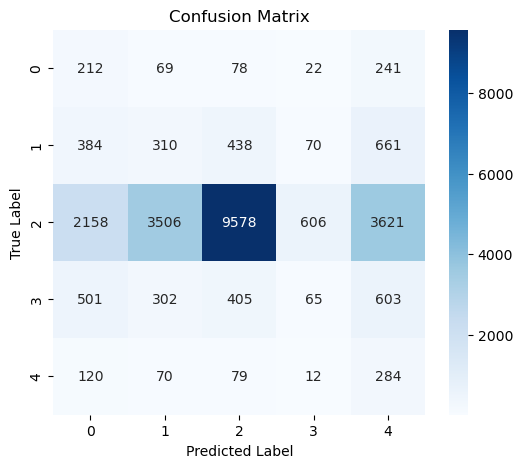

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# 计算分类准确率
accuracy = accuracy_score(scaler_test['return_class'], scaler_test['predicted_class'])
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# 打印分类报告（包含 Precision, Recall, F1-score）
print("Classification Report:")
print(classification_report(scaler_test['return_class'], scaler_test['predicted_class']))

# 绘制混淆矩阵
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(scaler_test['return_class'], scaler_test['predicted_class']), annot=True, cmap='Blues', fmt='d', 
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<Axes: >

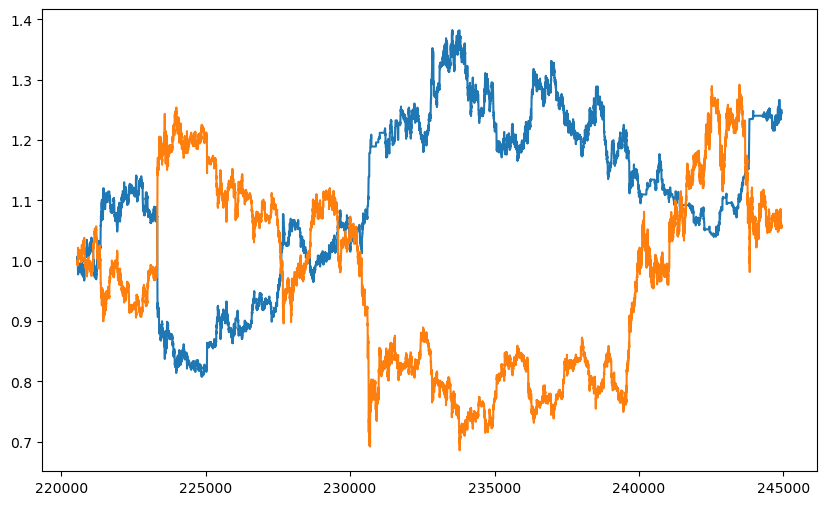

In [26]:
# strategy 1 
# no transaction fee
test['position'] = test['predicted_return'].apply(lambda x: -1 if x < 0.0001 else 0)

test['strategy_return'] = test['position'] * test['return_15m']
(1 + test['strategy_return']).cumprod().plot(figsize=(10,6))
(1 + test['return_15m']).cumprod().plot(figsize=(10,6))

In [140]:
(test['predicted_return'] - test['return_15m']).abs().sum()

54.45243369848124

In [141]:
(test['return_15m']).abs().sum()

53.472924825905814

In [159]:
# strategy 2
# no transaction fee
# 交易策略实现
def trading_strategy(predicted_class, current_position):
    """
    根据预测类别调整仓位：
    0 - 大跌：空仓或做空
    1 - 下跌：减少持仓
    2 - 震荡：维持现有仓位
    3 - 上涨：增加持仓
    4 - 大涨：全仓或加杠杆
    """
    if predicted_class == 0:
        return -1  # 清仓或做空
    elif predicted_class == 1:
        return max(-1, current_position - 0.5)  # 减少仓位
    elif predicted_class == 2:
        return current_position  # 维持仓位
    elif predicted_class == 3:
        return min(1, current_position + 0.5)  # 增加仓位
    elif predicted_class == 4:
        return 1  # 满仓
    return current_position

# 应用策略
scaler_test['position'] = 0  # 初始仓位
for i in range(1, len(test)):
    scaler_test.loc[scaler_test.index[i], 'position'] = trading_strategy(scaler_test.loc[scaler_test.index[i], 'predicted_class'], scaler_test.loc[scaler_test.index[i-1], 'position'])


/var/folders/lb/bpxk7kxj49x_zyw9f2vy9yj80000gn/T/ipykernel_64038/2217932362.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  scaler_test.loc[scaler_test.index[i], 'position'] = trading_strategy(scaler_test.loc[scaler_test.index[i], 'predicted_class'], scaler_test.loc[scaler_test.index[i-1], 'position'])


In [160]:
scaler_test['position']

220546    0.0
220547    0.0
220548    0.0
220549    0.0
220550    0.0
         ... 
244936   -0.5
244937    0.0
244938    0.5
244939    1.0
244940    1.0
Name: position, Length: 24395, dtype: float64

<Axes: >

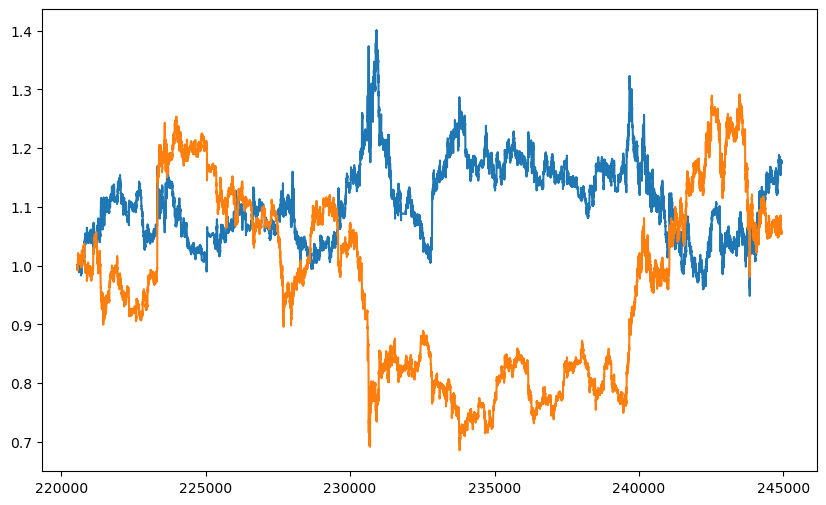

In [161]:
scaler_test['strategy_return'] = scaler_test['position'] * scaler_test['return_15m']
(1 + scaler_test['strategy_return']).cumprod().plot(figsize=(10,6))
(1 + scaler_test['return_15m']).cumprod().plot(figsize=(10,6))